In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from torch.utils.data import random_split

In [2]:
import torch,torchvision

In [3]:
#importing dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
trainn = datasets.MNIST(root = 'data',train = True,transform = ToTensor(),download = True,)
trainn, validd = random_split(trainn,[50000,10000])
testt = datasets.MNIST(root = 'data', train = False, transform = ToTensor())

In [4]:
trainn

In [5]:
testt

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [6]:
#Hyperparameters
epochs = 5
batch = 100
alpha = 0.001

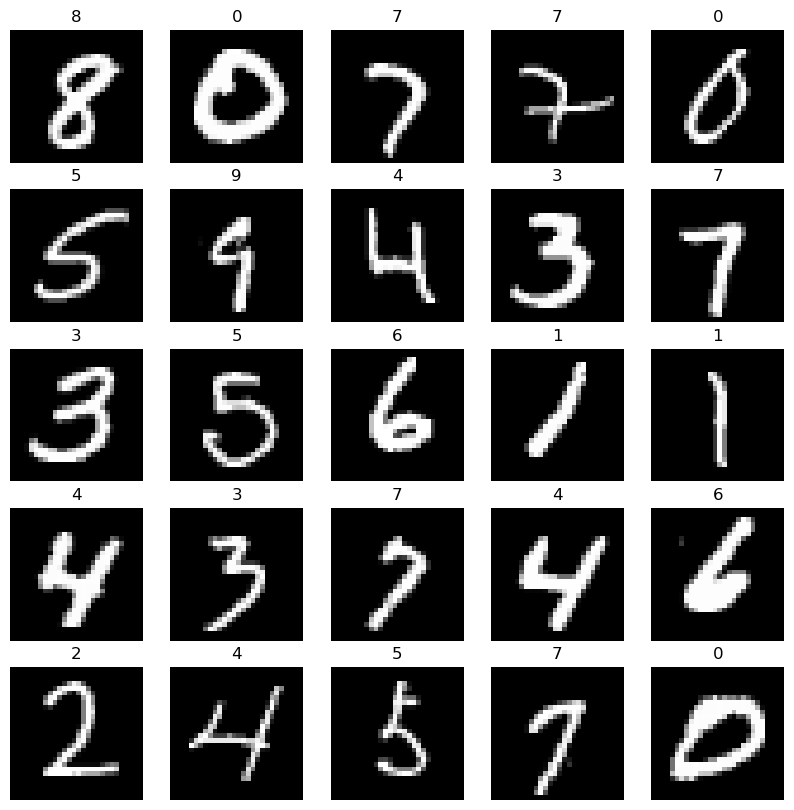

In [7]:
#Visualisation
figure = plt.figure(figsize=(10, 10))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainn), size=(1,)).item()
    img, label = trainn[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [8]:
#dataloader creation
#creates an iterable dataset object and iterates over it in batches
from torch.utils.data import DataLoader
train_loader = DataLoader ( dataset=  trainn, batch_size = batch)
valid_loader = DataLoader (dataset = validd, batch_size = batch, )
test_loader = DataLoader ( dataset = testt, batch_size= batch)

In [9]:
#CNN Model
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5,stride=1,padding=2,)
                                   ,nn.ReLU()
                                   ,nn.MaxPool2d(kernel_size=2),)
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 5, 1, 2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2),)
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        x = self.out(x)
        return x    # return x for visualization

In [10]:
cnn = CNN()
if torch.cuda.is_available():
    cnn = cnn.cuda()

In [11]:
criterion = nn.CrossEntropyLoss()   

In [12]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = alpha)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [13]:
min_valid_loss = np.inf

for i in range(epochs):
    train_loss = 0.0
    cnn.train()     # Optional when not using Model Specific layer
    for data, labels in train_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        target = cnn(data)
        loss = criterion(target,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    valid_loss = 0.0
    cnn.eval()     # Optional when not using Model Specific layer
    for data, labels in valid_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        target = cnn(data)
        loss = criterion(target,labels)
        valid_loss = loss.item() * data.size(0)

    print(f'Epoch {i+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(valid_loader)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(cnn.state_dict(), './Digit_Detector.pt') 

Epoch 1 		 Training Loss: 0.2620968997627497 		 Validation Loss: 0.09192905575037003
Validation Loss Decreased(inf--->9.192906) 	 Saving The Model
Epoch 2 		 Training Loss: 0.06985785567574203 		 Validation Loss: 0.059778738766908646
Validation Loss Decreased(9.192906--->5.977874) 	 Saving The Model
Epoch 3 		 Training Loss: 0.050917559012770654 		 Validation Loss: 0.05750532075762749
Validation Loss Decreased(5.977874--->5.750532) 	 Saving The Model
Epoch 4 		 Training Loss: 0.04058935130108148 		 Validation Loss: 0.054385486990213394
Validation Loss Decreased(5.750532--->5.438549) 	 Saving The Model
Epoch 5 		 Training Loss: 0.03323103427526075 		 Validation Loss: 0.046838440001010895
Validation Loss Decreased(5.438549--->4.683844) 	 Saving The Model


In [14]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            test_output = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
    print('Test Accuracy of the model on the 10000 test images: %.2f'% (accuracy*100),'%')
    pass

test()

Test Accuracy of the model on the 10000 test images: 99.00 %


In [15]:
torch.save(cnn.state_dict(), './Digit_Detector.pt') 